In [118]:
import pandas as pd
from sklearn.preprocessing import StandardScaler



data = pd.read_csv('/Users/pan/Desktop/creditcard.csv')
data.head()
data.isnull().any()
#print(data[data.isnull().values==True])
data.shape

(284807, 31)

In [119]:
count_class = pd.value_counts(data['Class'])
print(count_class, len(data))

0    284315
1       492
Name: Class, dtype: int64 284807


In [120]:
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time', 'Amount'], axis = 1)

In [121]:
import numpy as np
x = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']
numberFraud = len(data[data['Class'] == 1])
fraudIndex = np.array(data[data.Class == 1].index)
normalIndex = data[data.Class == 0].index
randomNormalIndex = np.random.choice(normalIndex, numberFraud)#replace = false?
randomNormalIndex = np.array(randomNormalIndex)
underSample_index = np.concatenate([fraudIndex, randomNormalIndex])
underSample = data.iloc[underSample_index, :]
len(underSample)

984

In [122]:
x_underSample = underSample.iloc[:, underSample.columns != 'Class']
y_underSample = underSample.iloc[:, underSample.columns == 'Class']
len(underSample[underSample.Class==1])/len(underSample)

0.5

In [123]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
x_undersample_train, x_undersample_test, y_undersample_train, y_undersample_test = train_test_split(x_underSample, y_underSample, test_size = 0.3)

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, classification_report


In [125]:
def kFold_scores(x_train_data, y_train_data):
    fold = KFold(len(y_train_data), 5, shuffle = False)
    c_range = [0.01, 0.1, 1, 10, 100]
    results = pd.DataFrame(index = range(len(c_range), 2), columns = ['C', 'score'])
    results['C'] = c_range
    j = 0
    for c in c_range:
        recall_accs = []
        for iteration, indices in enumerate(fold, start = 1):
            lr = LogisticRegression()
            lr.fit(x_train_data.iloc[indices[0], :], y_train_data.iloc[indices[0],:].values.ravel())
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1], :].values)
            recall_acc = recall_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            recall_accs.append(recall_acc)
            #print('Iteration ', iteration,': recall score = ', recall_acc)
        results.loc[j, 'score'] = np.mean(recall_accs)
        j += 1
        #print('Mean recall score ', np.mean(recall_accs))
    results['score'] = results['score'].astype('float64')
    best_c = results.loc[results['score'].idxmax()]['C']    
    return best_c

In [126]:
best_c = kFold_scores(x_undersample_train, y_undersample_train)
best_c

0.01

In [127]:
def plot_confusion_matrix(cm, classes, title = 'Confusion Matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('Predicted label')

[[137  12]
 [ 11 136]]
Recall metric in the testing dataset:  0.9251700680272109


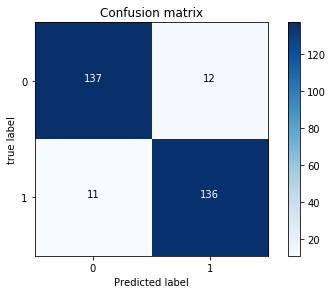

In [129]:
import itertools
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(x_undersample_train, y_undersample_train.values.ravel())
y_pred_undersample = lr.predict(x_undersample_test.values)

#print(y_pred_undersample)
#print(y_undersample_train.values.ravel())

cnf_matrix = confusion_matrix(y_undersample_test, y_pred_undersample)

np.set_printoptions(precision = 2)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix')
plt.show()


[[77406  7866]
 [   12   159]]
Recall metric in the testing dataset:  0.9298245614035088


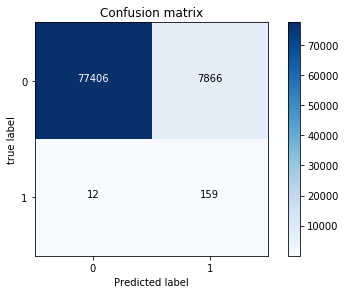

In [130]:
import itertools
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(x_undersample_train, y_undersample_train.values.ravel())
y_pred = lr.predict(x_test.values)

cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

np.set_printoptions(precision = 2)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix')
plt.show()


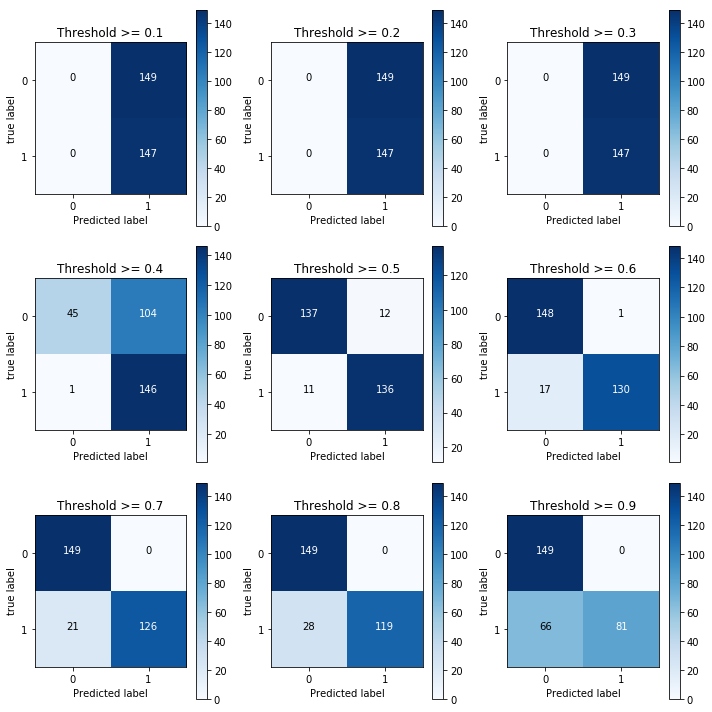

In [132]:
lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(x_undersample_train, y_undersample_train.values.ravel())
y_pred_undersampe_pro = lr.predict_proba(x_undersample_test.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (10, 10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersampe_pro[:, 1] > i
    plt.subplot(3, 3, j)
    j += 1
    
    cnf_matrix = confusion_matrix(y_undersample_test, y_test_predictions_high_recall)
    np.set_printoptions(precision = 2)
    
    class_name = [0, 1]
    plot_confusion_matrix(cnf_matrix, classes = class_name, title = 'Threshold >= %s'%i)

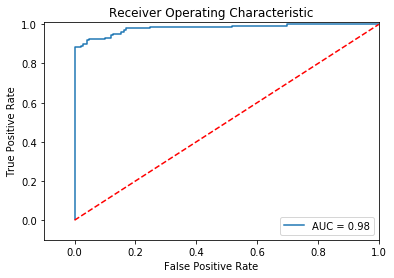

In [134]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, \
recall_score, classification_report, auc
lr = LogisticRegression(C = best_c, penalty='l1')
# decision_function(X): Predict confidence scores for samples.
# 模型学习、预测每个样本的得分
y_pred_undersample_score = lr.fit(x_undersample_train, y_undersample_train.values.ravel())\
.decision_function(x_undersample_test.values)
# 计算fpr、tpr
fpr, tpr, thresholds = roc_curve(y_undersample_test.values.ravel(), y_pred_undersample_score)
roc_auc = auc(fpr, tpr)
# 绘制ROC曲线
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

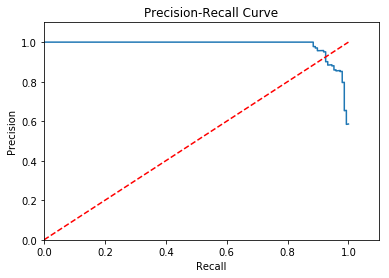

In [135]:
# 计算precision和recall
precision, recall, threshold = precision_recall_curve(y_undersample_test.values.ravel(), y_pred_undersample_score)
# 绘制P-R曲线
plt.title('Precision-Recall Curve')
plt.plot(recall, precision)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.10])
plt.ylim([0.0, 1.10])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()